# 0. Import libraries

In [1]:
# 0. Import

import os, sys, json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


In [2]:
import celloracle as co
co.__version__

'0.6.3'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

## 0.1. Check installation

Celloracle uses some R libraries in network analysis. 
Please make sure that all dependent R libraries are installed on your computer.
You can test the installation with the following command.

In [4]:
co.network_analysis.test_R_libraries_installation()

R path: /home/lorena/anaconda3/envs/celloracle_env/bin/R
checking R library installation: igraph -> OK
checking R library installation: linkcomm -> OK
checking R library installation: rnetcarto -> OK


## 0.2. Make a folder to save graph

In [5]:
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed gene expression data (anndata)
Please refer to the previous notebook in the tutorial for an example of how to process scRNA-seq data.

In [6]:
# Load data. !!Replace the data path below when you use another data.
adata = sc.read_h5ad("./inputs/pancreas_data.h5ad")

In [7]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# 2. Initiate Oracle object

Celloracle has a custom called Oracle. We can use Oracle for the data preprocessing and GRN inference steps.
The Oracle object stores all of necessary information and does the calculations with its internal functions.
We instantiate an Oracle object, then input the gene expression data (anndata) and a TFinfo into the Oracle object.

In [8]:
# Instantiate Oracle object
oracle = co.Oracle()

Ne## 2.1. load gene expression data into oracle object.

When you load a scRNA-seq data, please enter the name of clustering data and dimensional reduction data.
The clustering data should be to be stored in the attribute of "obs" in the anndata.
Dimensional reduction data suppose to be stored in the attribute of "obsm" in the anndata.
You can check these data by the following command.

If you are not familiar with anndata, please look at the documentation of annata (https://anndata.readthedocs.io/en/stable/) or Scanpy (https://scanpy.readthedocs.io/en/stable/).

For the celloracle analysis, the anndata shoud include (1) gene expression count, (2) clustering information, (3) trajectory (dimensional reduction embeddings) data. Please refer to another notebook for more information on anndata preprocessing.



In [9]:
# show data name in anndata
print("metadata columns :", list(adata.obs.columns))
print("dimensional reduction: ", list(adata.obsm.keys()))

metadata columns : ['clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts']
dimensional reduction:  ['X_pca', 'X_umap']


In [10]:
# In this notebook, we use raw mRNA count as an input of Oracle object.
#adata.X = adata.raw.X.copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="clusters",
                                   embedding_name="X_umap", 
                                   transform=None) #already done using scVelo

## 2.2. Load TFinfo into oracle object

In [11]:
with open('TF_targets_pancreas.json', 'r') as fp:
    TF_info = json.load(fp)

In [12]:
# Add TF information 
oracle.addTFinfo_dictionary(TF_info)

# 3. Knn imputation
Celloracle uses almost the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we need PCA and PC selection first.

## 3.1. PCA

24


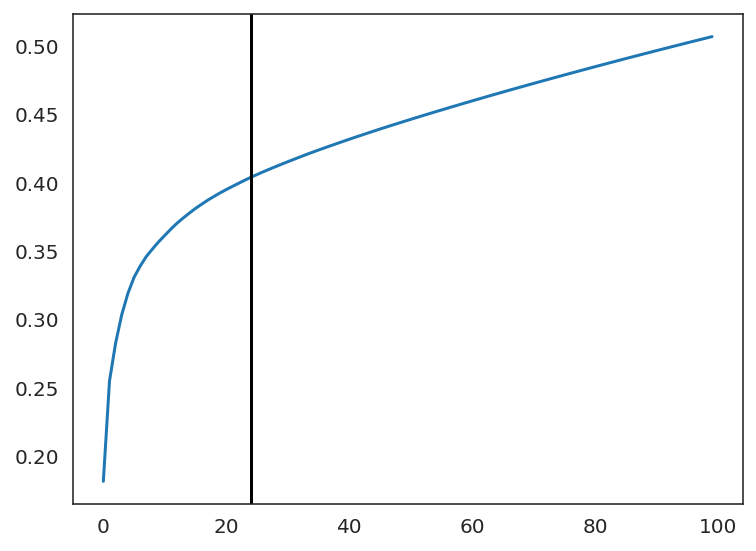

In [13]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)
n_comps = min(n_comps, 50)

In [14]:
oracle.pcs[:, :24].shape

(3696, 24)

## 3.2. KNN imputation

Estimate the optimal number of nearest neighbors for KNN imputation.

In [15]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :3696


In [16]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :92


In [17]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=12)

# 4. Save and Load.

Celloracle has some custom-classes: Links, Oracle and TFinfo.
You can save such an object using "to_hdf5".

Please use "load_hdf5" function to load the file.


In [18]:
# Save oracle object.
oracle.to_hdf5("Pancreas_data.celloracle.oracle")

In [19]:
# Load file.
#oracle = co.load_hdf5("Pancreas_data.celloracle.oracle")

# 5. GRN calculation
The next step is constructing a cluster-specific GRN for all clusters.

You can calculate  GRNs with the "get_links" function, and the function returns GRNs as a Links object.
The Links object stores inferred GRNs and the corresponding metadata. You can do network analysis with the Links object.

The GRN will be calculated for each cluster/sub-group.

The GRNs can be calculated at any arbitrary unit as long as the clustering information is stored in anndata.

In [20]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [21]:
# check data
sc.tl.draw_graph(adata)

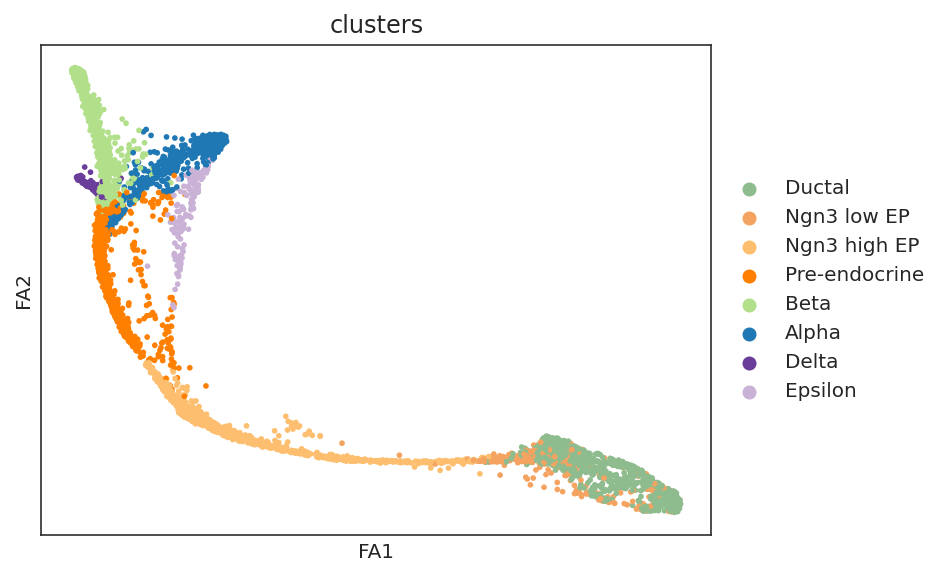

In [22]:
sc.pl.draw_graph(adata, color = "clusters")

## 5.1. Get GRNs

In [23]:
oracle.adata.obs

,clusters_coarse,clusters,S_score,G2M_score,initial_size_spliced,initial_size_unspliced,initial_size,n_counts
index,,,,,,,,
AAACCTGAGAGGGATA,Pre-endocrine,Pre-endocrine,-0.224902,-0.252071,4954.0,1575.0,4954.0,5410.060059
AAACCTGAGCCTTGAT,Ductal,Ductal,-0.014707,-0.232610,7071.0,978.0,7071.0,5476.578125
AAACCTGAGGCAATTA,Endocrine,Alpha,-0.171255,-0.286834,4070.0,1095.0,4070.0,5436.109863
AAACCTGCATCATCCC,Ductal,Ductal,0.599244,0.191243,8362.0,1655.0,8362.0,5505.859863
AAACCTGGTAAGTGGC,Ngn3 high EP,Ngn3 high EP,-0.179981,-0.126030,5026.0,1014.0,5026.0,5473.050781
...,...,...,...,...,...,...,...,...
TTTGTCAAGTGACATA,Pre-endocrine,Pre-endocrine,-0.235896,-0.266101,9219.0,2488.0,9219.0,5448.891602
TTTGTCAAGTGTGGCA,Ngn3 high EP,Ngn3 high EP,0.279374,-0.204047,7298.0,943.0,7298.0,5568.489258
TTTGTCAGTTGTTTGG,Ductal,Ductal,-0.045692,-0.208907,5234.0,789.0,5234.0,5585.724121


In [24]:
len(oracle.TFdict.keys())

1857

In [25]:
from celloracle.network_analysis.network_construction import _fit_GRN_for_network_analysis
from celloracle.trajectory.oracle_utility import _adata_to_df
from celloracle.utility import standard
from celloracle.network.net_core import Net

In [26]:
gem_imputed = _adata_to_df(oracle.adata, "imputed_count") #imputed count
gem_imputed_std = standard(gem_imputed) #standardize imputed count
cluster_info = oracle.adata.obs["clusters"] #map cell-cluster

In [27]:
# Ngn3 high EP Cluster

cells_in_the_cluster_bool = (cluster_info == "Ngn3 high EP")
gem_ = gem_imputed[cells_in_the_cluster_bool]
gem_std = gem_imputed_std[cells_in_the_cluster_bool]

In [54]:
gem_

,Sntg1,Snhg6,Ncoa2,Sbspon,Ube2w,Mcm3,Fam135a,Adgrb3,Tmem131,Tbc1d8,...,Sh3kbp1,Map3k15,Rai2,Rbbp7,Ap1s2,Tmem27,Uty,Ddx3y,Eif2s3y,Erdr1
AAACCTGGTAAGTGGC,0.0,0.331317,0.043057,0.008682,0.000000,0.082468,0.240271,0.057021,0.067412,0.091982,...,0.082975,0.388444,0.000000,0.524009,0.000000,0.008481,0.017866,0.081195,0.162490,0.260789
AAACGGGGTGAAATCA,0.0,0.385928,0.035375,0.008682,0.007630,0.150678,0.222513,0.026083,0.088173,0.160246,...,0.150213,0.402316,0.000000,0.486399,0.043597,0.016383,0.034936,0.214120,0.187825,0.338125
AAACGGGTCAAACAAG,0.0,0.450880,0.035102,0.007535,0.011573,0.198715,0.386362,0.006806,0.093229,0.154616,...,0.026738,0.196244,0.000000,0.501988,0.008878,0.030245,0.004476,0.064922,0.067473,0.151591
AAATGCCCACATCTTT,0.0,0.424607,0.040797,0.007535,0.004444,0.261542,0.284179,0.000000,0.100554,0.131965,...,0.013209,0.118344,0.000000,0.657292,0.000000,0.019998,0.011014,0.127707,0.136032,0.242412
AAATGCCCACCAACCG,0.0,0.445172,0.033654,0.000000,0.007630,0.105157,0.261211,0.054139,0.056974,0.199251,...,0.124835,0.371030,0.000000,0.405398,0.007404,0.000000,0.007793,0.184873,0.236252,0.249578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTATGCAGCGTCTAT,0.0,0.493896,0.043522,0.042269,0.000000,0.189344,0.353881,0.000000,0.077320,0.041018,...,0.007831,0.052959,0.000000,0.799565,0.000000,0.042605,0.000000,0.032083,0.095407,0.188794
TTTGCGCTCACTTACT,0.0,0.471445,0.026901,0.015015,0.011573,0.227360,0.358488,0.000000,0.109150,0.142924,...,0.017860,0.145426,0.000000,0.656682,0.000000,0.035931,0.004476,0.084535,0.072119,0.199921
TTTGGTTCACGAAGCA,0.0,0.470040,0.007981,0.006673,0.000000,0.262745,0.240832,0.020747,0.118141,0.233242,...,0.090943,0.293970,0.000000,0.350902,0.023238,0.014647,0.030347,0.182909,0.254784,0.229431
TTTGGTTTCACTTACT,0.0,0.485508,0.028303,0.071193,0.000000,0.282718,0.269129,0.000000,0.116147,0.032099,...,0.006683,0.030014,0.000000,0.939759,0.000000,0.060248,0.021189,0.087583,0.163748,0.218731


In [28]:
gem_.shape

(642, 2000)

In [29]:
tn_ = Net(gene_expression_matrix=gem_, gem_standerdized=gem_std, TFinfo_dic=oracle.TFdict, verbose=False)

In [30]:
tn_.fit_All_genes(bagging_number=20, alpha=10, verbose=1)

  0%|          | 0/1857 [00:00<?, ?it/s]

Lets see what this fit_All_genes function does step by step

In [31]:
target_genes = tn_.all_genes

In [45]:
#the function above is equivalent to this function 
#tn_.fit_genes(target_genes=target_genes, bagging_number=20, alpha=10, verbose=1)

  0%|          | 0/177 [00:00<?, ?it/s]

In [32]:
#what does fit genes does step by step
genes = np.array(list(set(target_genes).intersection(tn_.TFdict.keys()))) # these are the transcription factors
genes = np.array(list(set(genes).intersection(tn_.all_genes))) #same, I do not know why is repeated

In [33]:
N = len(genes)
log_step = 10

In [34]:
from celloracle.network.regression_models import get_bagging_ridge_coefs as _get_bagging_ridge_coefs

In [35]:
coefs_Ngn3 = _get_bagging_ridge_coefs(target_gene="Neurog3",
                                                     gem=gem_,
                                                     gem_scaled=gem_std,
                                                     TFdict=oracle.TFdict,
                                                     cellstate=None,
                                                     bagging_number=20,
                                                     scaling=True,
                                                     alpha=10,
                                                     solver="auto")

In [36]:
reggenes = oracle.TFdict["Neurog3"]
allgenes_detected = list(gem_.columns)
reggenes = list(set(reggenes).intersection(allgenes_detected))
reggenes.remove("Neurog3")

In [37]:
reg_all = reggenes.copy()

In [39]:
len(reggenes) #88 transcription factors influence Neurog3 including itself

88

In [40]:
data = gem_std[reg_all]
label = gem_["Neurog3"]

In [41]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge, BayesianRidge

A Bagging regressor.

A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

This algorithm encompasses several works from the literature. When random subsets of the dataset are drawn as random subsets of the samples, then this algorithm is known as Pasting [1]. If samples are drawn with replacement, then the method is known as Bagging [2]. When random subsets of the dataset are drawn as random subsets of the features, then the method is known as Random Subspaces [3]. Finally, when base estimators are built on subsets of both samples and features, then the method is known as Random Patches [4].



In [42]:
 model = BaggingRegressor(base_estimator=Ridge(alpha=10, 
                                               solver="auto", 
                                               random_state=123),
                          n_estimators=20, #20 samples
                          bootstrap=True, #samples with replacement
                          max_features=0.8, #number of features to draw from X 
                                            #to train each base estimator 
                                            #(without replacement)
                          n_jobs=16,
                          verbose=False,
                          random_state=123)

In [43]:
model.fit(data, label)

BaggingRegressor(base_estimator=Ridge(alpha=10, random_state=123),
                 max_features=0.8, n_estimators=20, n_jobs=16, random_state=123,
                 verbose=False)

In [56]:
#these are the coefficients at the end
coefs_Ngn3

,Foxn3,Ebf1,Nkx2-2,Egr1,Nr1h4,Nr4a1,Ovol2,Pax6,Zfp148,Rest,...,Mxd4,Hbp1,Fos,Atf6,Zscan26,Creb1,Meis2,Arx,Tfcp2,Hes1
0,NaN,NaN,0.016039,0.010742,NaN,-0.029797,0.033227,-0.002692,-0.069203,-0.091184,...,-0.042809,NaN,-0.113793,NaN,-0.005672,0.026325,NaN,-0.016033,0.000473,NaN
1,NaN,0.000634,0.024862,0.008251,-0.025029,NaN,NaN,-0.005806,-0.036893,-0.068545,...,-0.021852,NaN,-0.071289,NaN,0.002541,NaN,-0.076527,NaN,0.004722,-0.101850
2,-0.018825,-0.002490,0.026973,0.030244,-0.039954,NaN,NaN,NaN,-0.046365,NaN,...,-0.034238,0.029513,-0.097172,-0.021858,0.007983,0.004410,-0.081568,-0.029611,0.003406,-0.106087
3,NaN,-0.014545,0.024485,0.009312,-0.022965,-0.018029,0.042661,0.008073,-0.017753,-0.086110,...,-0.026993,0.011044,-0.091217,-0.021500,0.004807,NaN,-0.101535,-0.037906,-0.001943,-0.106709
4,-0.001494,NaN,0.024035,0.020931,-0.029523,-0.028542,0.031843,-0.000547,-0.048274,-0.071087,...,-0.064374,NaN,-0.092609,-0.025794,-0.004844,0.008099,-0.097859,-0.034951,0.009057,NaN
5,-0.006224,NaN,0.022150,0.011308,-0.026495,-0.020418,NaN,-0.015201,-0.031312,-0.065332,...,-0.052667,NaN,-0.097700,-0.025727,0.000325,0.022677,-0.108043,-0.022162,0.008194,-0.099644
6,-0.005896,0.027094,0.025774,0.009592,NaN,NaN,0.031082,0.002751,-0.045492,-0.084963,...,-0.052013,0.013532,-0.106133,-0.028312,0.003977,0.022505,-0.100220,-0.028160,-0.001343,-0.086311
7,0.003447,NaN,0.021112,-0.019889,-0.024697,-0.054699,0.079645,0.030452,-0.026224,-0.111263,...,NaN,0.013845,NaN,0.003912,-0.008606,0.012494,-0.136660,-0.041516,NaN,-0.108322
8,NaN,-0.002007,0.028321,0.014238,-0.022852,-0.028255,0.028369,0.013762,-0.077686,NaN,...,-0.040733,0.002076,-0.112825,-0.045461,0.003422,0.022759,-0.111331,-0.031774,-0.000681,-0.087725
9,-0.018331,0.000840,0.048119,0.012233,-0.027176,-0.032547,0.048951,0.007225,-0.050552,-0.082492,...,NaN,-0.007871,-0.083422,-0.032098,0.011091,0.021508,-0.092156,NaN,NaN,NaN


In [49]:
mean = coefs_Ngn3.mean()
#p = df.apply(lambda x: ttest_1samp(x.dropna(), 0)[1])
#neg_log_p = -np.log10(p.fillna(1))

Foxn3    -0.007632
Ebf1      0.000420
Nkx2-2    0.025730
Egr1      0.010079
Nr1h4    -0.027192
            ...   
Creb1     0.018236
Meis2    -0.101612
Arx      -0.029963
Tfcp2     0.003613
Hes1     -0.100524
Length: 88, dtype: float64

In [51]:
from scipy.stats import ttest_1samp

In [52]:
p = coefs_Ngn3.apply(lambda x: ttest_1samp(x.dropna(), 0)[1])

In [53]:
p

Foxn3     2.919978e-03
Ebf1      8.925073e-01
Nkx2-2    1.551083e-08
Egr1      3.711296e-02
Nr1h4     2.981391e-09
              ...     
Creb1     3.493923e-08
Meis2     2.516690e-15
Arx       1.562724e-09
Tfcp2     1.186741e-02
Hes1      6.021185e-12
Length: 88, dtype: float64